In [8]:
from PIL import Image
import os
import numpy as np
from matplotlib import pyplot as plt
import yaml
import pickle
import pandas as pd
import seaborn as sns

In [32]:
for _, dir, files in os.walk('.'):
    break
dir = [d for d in dir if 'model' in d]
conf_file = [d for d in files if 'yaml' in d][0]

dir = ['OneActor', 'Mask', "Mask_0.5", "Mask_0.25"]

with open(conf_file, "r") as f:
    config = yaml.safe_load(f)

for _, _, files in os.walk('./inference_sdxl'):
    break

In [33]:
dir_files = {}
name_files = set()
for d in dir:
    dir_files[d] = {}
    dir_files[d]['files'] = []
    for _, cd, fl in os.walk(f'./{d}'):
        break
    conf_file = "log_train.log"
    # metric = pd.read_csv(f"./{d}/metrics.csv")
    try:
        with open(f"./{d}/{conf_file}", "r") as f:
            config = yaml.safe_load(f)
    except:
        config = {'use_mask': False}
    dir_files[d]['config'] = config
    # dir_files[d]['metric'] = metric
    if 'inference' in cd:
        for _, _, files in os.walk(f'./{d}/inference'):
            break
        dir_files[d]['files'] += [f for f in files if 'jpg' in f]
        name_files = name_files.union(set([f for f in files if 'jpg' in f]))

In [34]:
for key in dir_files:
    print(key, dir_files[key]['metric'].agg({"CLIPScore":"mean", "dreamsim":"mean"}).values)

KeyError: 'metric'

In [35]:
from typing import Union, List
def view_images(images: Union[np.ndarray, List],
                num_rows: int = 1,
                offset_ratio: float = 0.02,
                display_image: bool = True,
                downscale_rate=None) -> Image.Image:
    """ Displays a list of images in a grid. """
    if type(images) is list:
        num_empty = len(images) % num_rows
    elif images.ndim == 4:
        num_empty = images.shape[0] % num_rows
    else:
        images = [images]
        num_empty = 0

    empty_images = np.ones(images[0].shape, dtype=np.uint8) * 255
    images = [image.astype(np.uint8) for image in images] + [empty_images] * num_empty
    num_items = len(images)

    h, w, c = images[0].shape
    offset = int(h * offset_ratio)
    num_cols = num_items // num_rows
    image_ = np.ones((h * num_rows + offset * (num_rows - 1),
                      w * num_cols + offset * (num_cols - 1), 3), dtype=np.uint8) * 255
    for i in range(num_rows):
        for j in range(num_cols):
            image_[i * (h + offset): i * (h + offset) + h:, j * (w + offset): j * (w + offset) + w] = images[
                i * num_cols + j]

    pil_img = Image.fromarray(image_)

    if downscale_rate:
        pil_img = pil_img.resize((int(pil_img.size[0] // downscale_rate), int(pil_img.size[1] // downscale_rate)))

    if display_image:
        display(pil_img)
    return pil_img


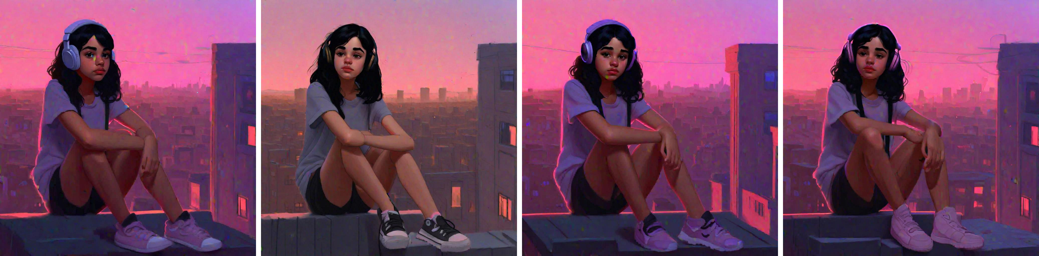

In [31]:
file_name = "perched_on_a_rooftop_at_dusk_with_headphones_on"
downscale_rate = 4

view_images([np.array(x) for x in [
    Image.open(f'./{d}/inference/{file_name}_step_100.jpg') for d in dir]], display_image=False, downscale_rate=downscale_rate)

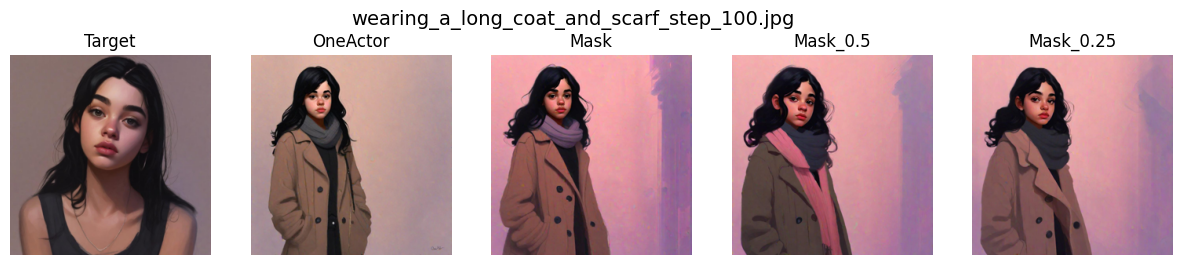

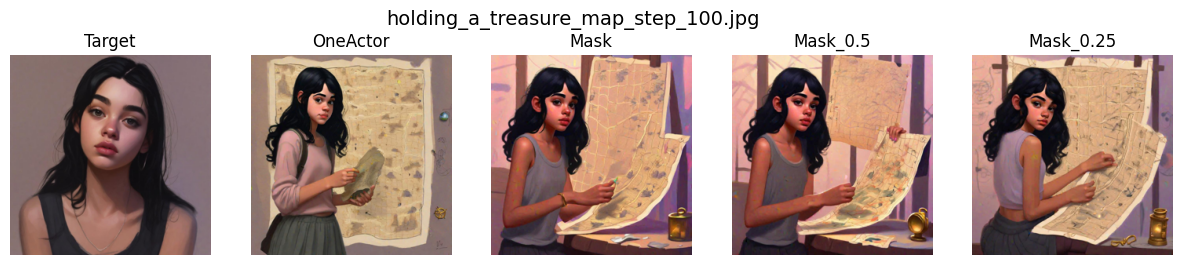

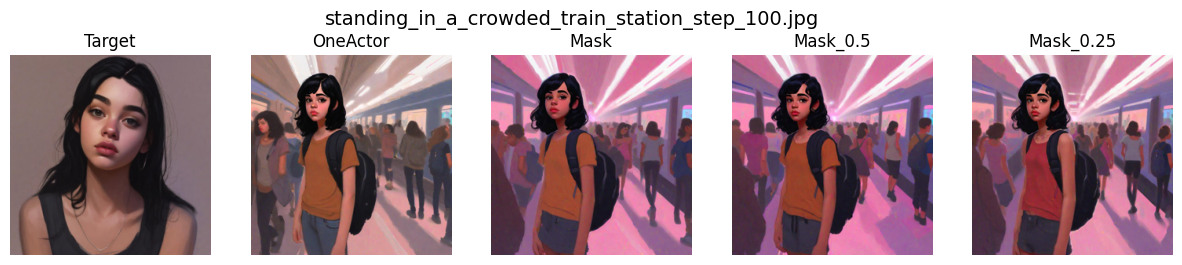

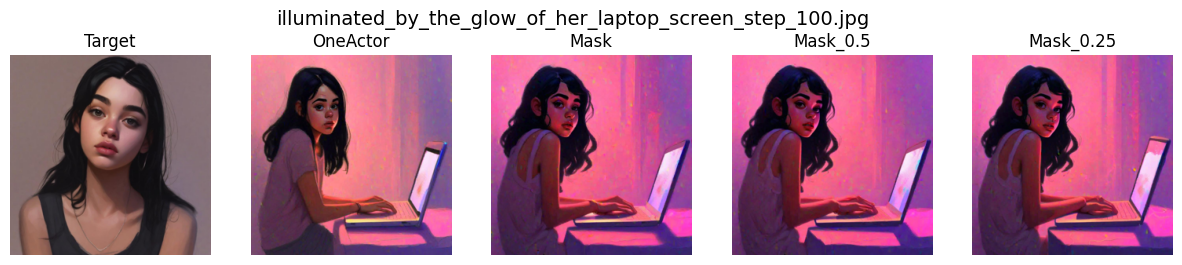

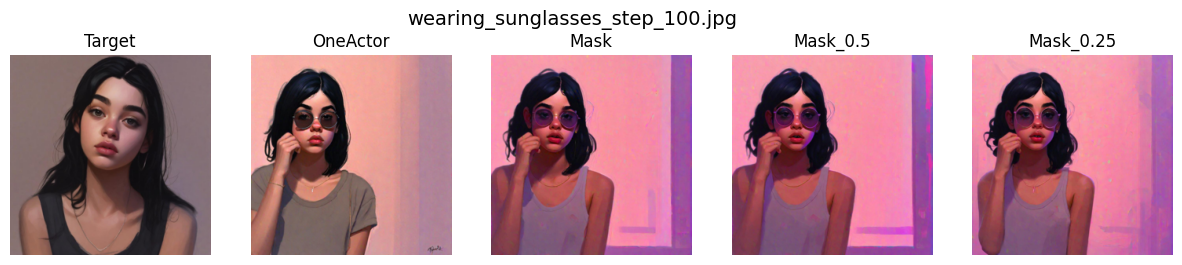

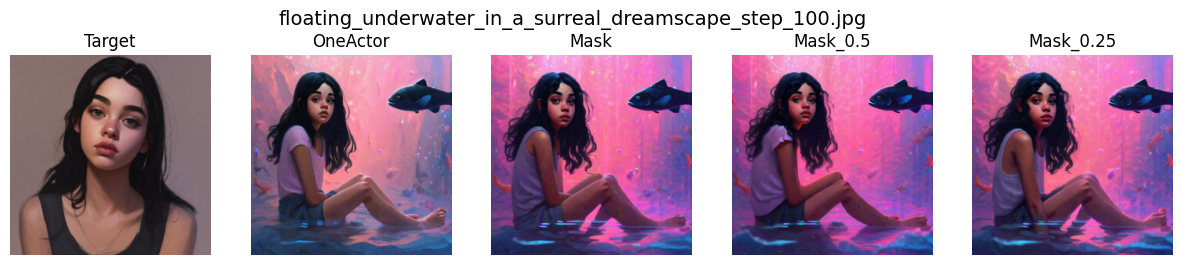

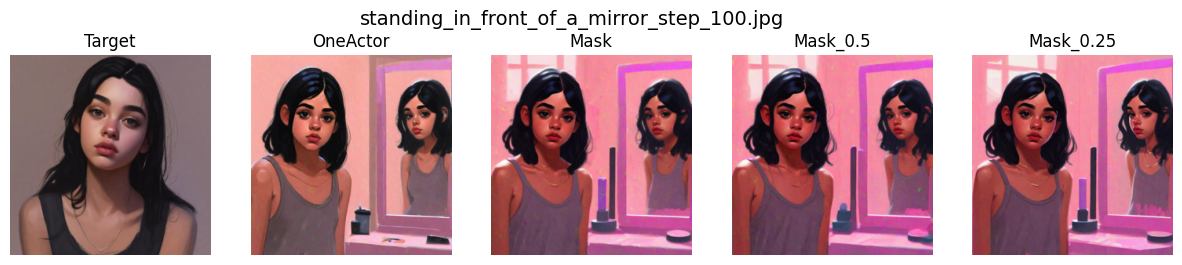

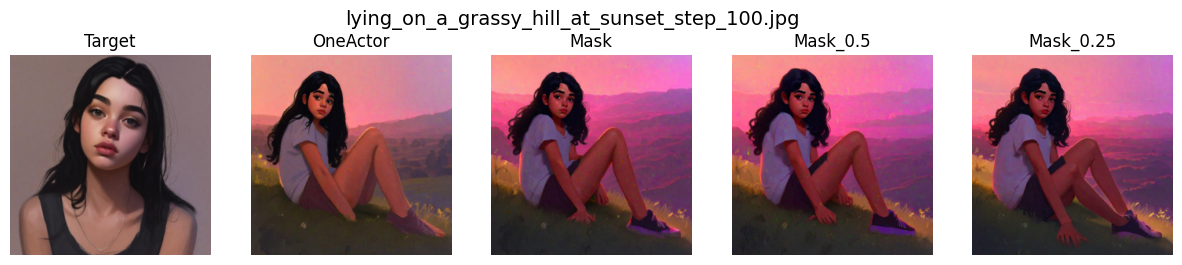

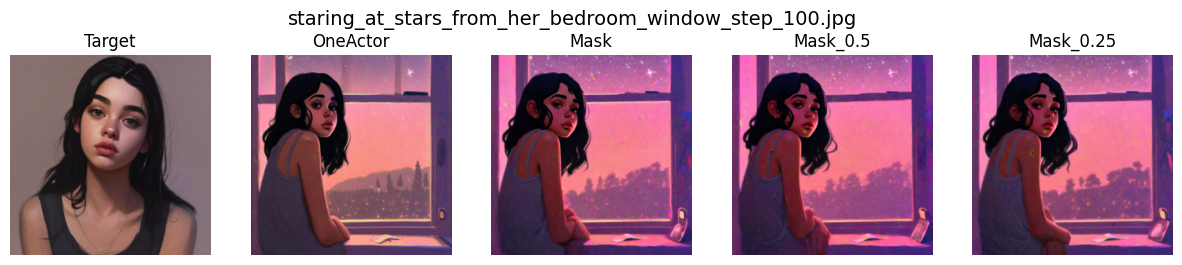

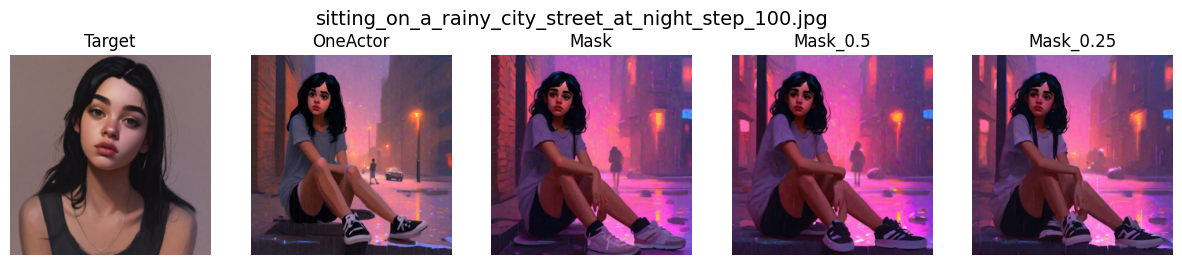

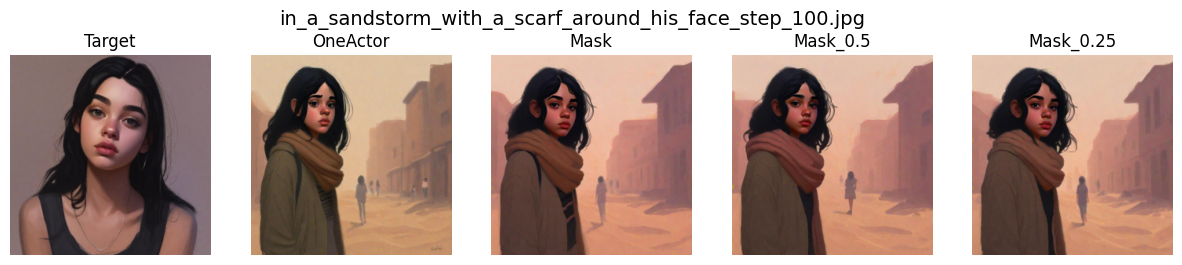

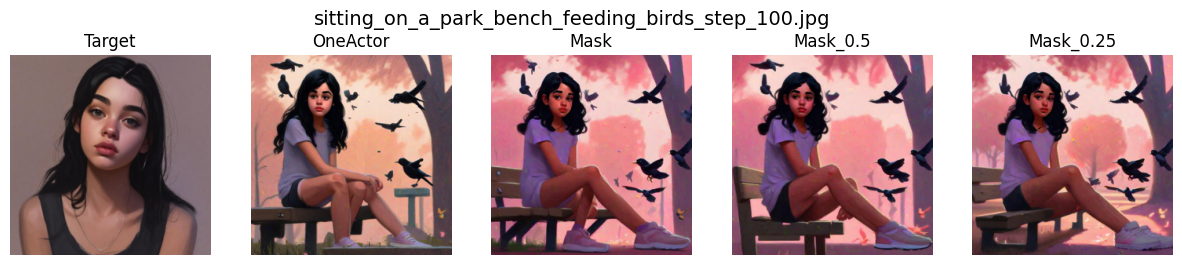

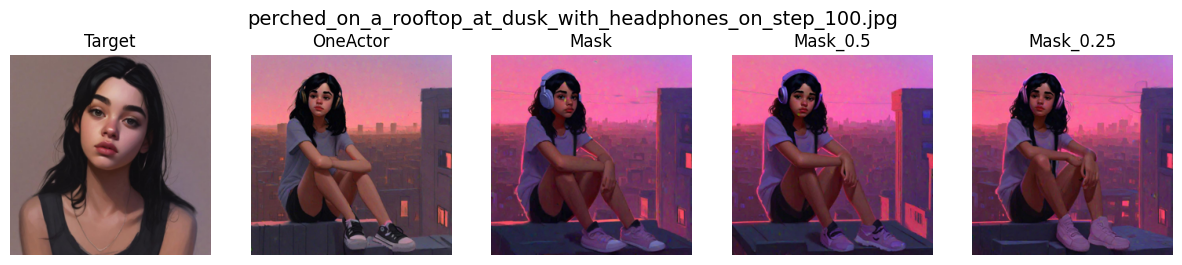

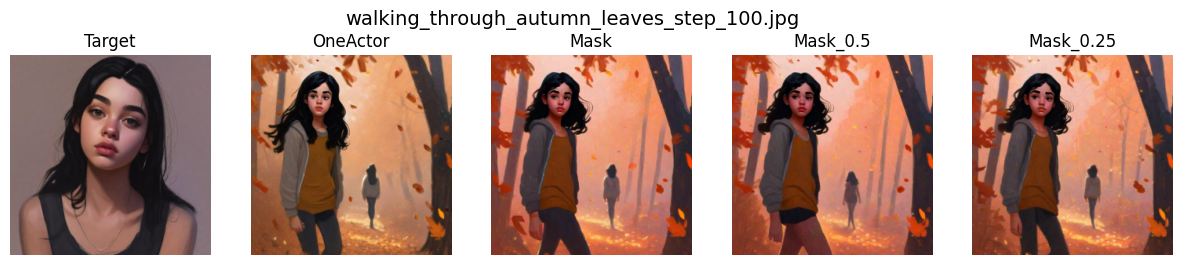

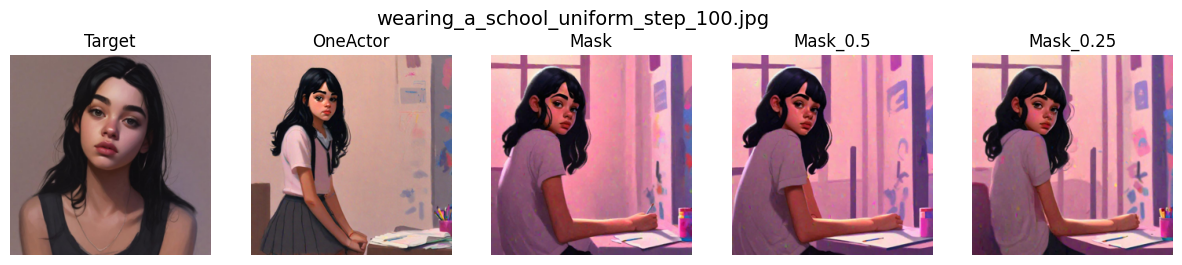

In [42]:
import os
os.makedirs(f"./reconciliation", exist_ok=True)

# 100, 80, 40, 20
for n, file_name in enumerate(name_files):
    if '100' not in file_name:
        continue
    f, axarr = plt.subplots(1, (len(dir) + 1) , figsize=(15, 3))
    axarr[0].imshow(Image.open('target.jpg').resize((256,256)))
    axarr[0].set_title("Target")
    axarr[0].axis('off')
    for m, d in enumerate(dir):
        
        if file_name in dir_files[d]['files']:
            axarr[m+1].imshow(Image.open(f'./{d}/inference/{file_name}').resize((256,256)))
            # if dir_files[d]['config']['use_mask']:
            #     title = f"mask"
            # else:
            #     title="OneActor"
            # df = dir_files[d]['metric']
            # df[df['index'] == file_name]
            # title = f"{d}\n{title}\n{df[df['index'] == file_name].values[0][1]}"
            # title += f"\n{100 - df[df['index'] == file_name].values[0][2]*100:0.1f}"
            # title += f"\n{df[df['index'] == file_name].values[0][3]*100:0.1f}"
            title = d
            axarr[m+1].set_title(title)
            axarr[m+1].axis('off')
    f.suptitle(f'{file_name}', fontsize=14)
    plt.show()
    f.savefig(f'./reconciliation/rec_{file_name}')       

In [34]:
df1 = dir_files["model_OneActor"]['metric']
df1['model'] = "OneActor"
df2 = dir_files["model_Mask"]['metric']
df2['model'] = "Mask"
df = pd.concat([df1, df2], axis=0)
df['dreamsimScore'] = 100 - df['dreamsim'] * 100 

In [22]:
df_agg = df.groupby(['model']).agg({'dreamsimScore':'mean', 'CLIPScore':'mean'}).reset_index()

<Axes: xlabel='CLIPScore', ylabel='dreamsimScore'>

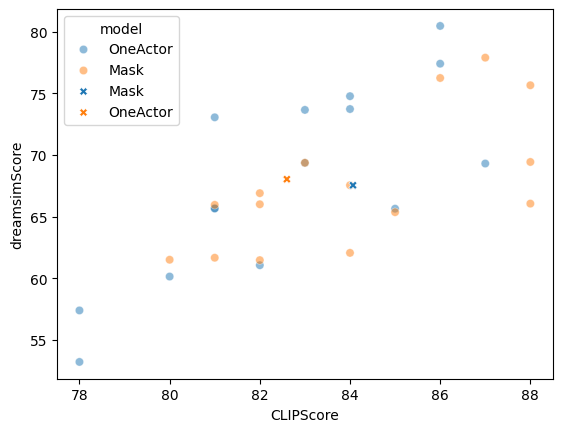

In [28]:
sns.color_palette("husl", 8)
sns.scatterplot(df,
    x='CLIPScore',
    y='dreamsimScore', hue="model", alpha=0.5)

sns.scatterplot(df_agg,
    x='CLIPScore',
    y='dreamsimScore', hue="model", marker='X')

<Axes: ylabel='dreamsimScore'>

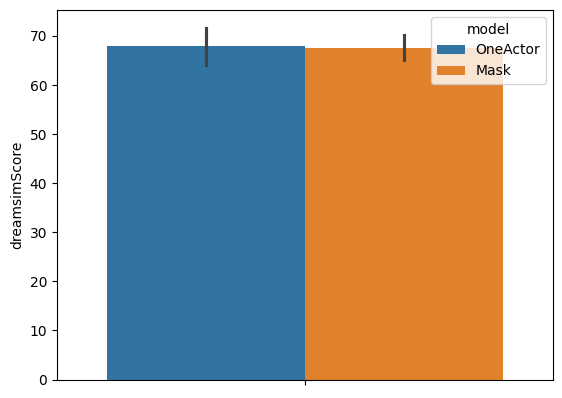

In [19]:
sns.color_palette("husl", 8)
sns.barplot(df, hue="model", y="dreamsimScore")

In [ ]:
!cp reconciliation.ipynb /workspace/Diploma/OneActor/notebooks